In [157]:
import numpy as np
import dolfin as df
import tqdm
from dolfin import inner, grad, dot

from glymphopt.datageneration import BoundaryConcentration
from glymphopt.io import read_mesh, read_function_data
from glymphopt.measure import measure
from glymphopt.operators import (
    mass_matrix, boundary_mass_matrix, stiffness_matrix, matrix_operator, bilinear_operator, matmul, zero_vector
)
from glymphopt.parameters import parameters_2d_default
from glymphopt.timesteppers import TimeStepper

In [313]:
def all_timepoints(dt, intervals):
    t0, _ = intervals[0]
    timesteppers = [subinterval_timestepper(dt, int_start, int_end) for int_start, int_end in intervals]
    return np.concatenate([[t0], *[ts.vector()[1:] for ts in timesteppers]])

def vector2coeff(x: np.ndarray, *args):
    return parameters_2d_default() | {key: xi for key, xi in zip(args, x)}

def coeff2vector(coefficients: dict[str, float], *args):
    return np.array([coefficients[key] for key in args])

class Model:
    def __init__(self, V, D=None, g=None):
        D = D or df.Identity(2)
        self.g = g or BoundaryConcentration(V)
        
        domain = V.mesh()
        dx = df.Measure("dx", domain)
        ds = df.Measure("ds", domain)
        
        u, v = df.TrialFunction(V), df.TestFunction(V)
        self.M = df.assemble(inner(u, v) * dx)
        self.DK = df.assemble(inner(D * grad(u), grad(v)) * dx)
        self.S = df.assemble(inner(u, v) * ds)
        self.g = g or BoundaryConcentration(V)
        
        
def gradient_finite_differences(F, x, h, **kwargs):
    return np.array([
        (
            F(x + (h * x[i]) * ei, **kwargs) 
            - F(x - (h * x[i]) * ei, **kwargs)
        ) / (2 * (h * x[i]))
        for i, ei in enumerate(np.eye(len(x)))
    ])


def gradient_sensitivities(F, x, **kwargs):
    return np.array([F(x, ei, **kwargs) for ei in np.eye(len(x))])

def measure_interval(n: int, td: np.ndarray, timestepper: TimeStepper):
    bins = np.digitize(td, timestepper.vector(), right=True)
    return list(np.where(n == bins)[0])

In [402]:
class InverseProblem:
    def __init__(self, data_path, dt=0.1, progress=True):
        self.progress = progress
        domain = read_mesh(data_path)
        self.td, self.Yd = read_function_data(data_path, domain, "concentration")
        self.timestepper = TimeStepper(dt, (self.td[0], self.td[-1]))
        self.V = self.Yd[0].function_space()
        self.model = Model(self.V, g=BoundaryConcentration(self.V))
        
    def F(self, x):
        Y = self.forward(x, self.timestepper)
        Ym = measure(self.timestepper, Y, self.td)
        _M_ = bilinear_operator(self.model.M)
        J = 0.5 * sum([
            _M_(Ym_i.vector() - Yd_i.vector(), Ym_i.vector() - Yd_i.vector()) 
            for Ym_i, Yd_i in zip(Ym, self.Yd)
        ])
        return J
    
    def gradF(self, x):
        model = self.model
        Y = self.forward(x, self.timestepper)
        Ym = measure(self.timestepper, Y, self.td)
        P = self.adjoint(x, self.timestepper, Ym)
        G = [matmul(model.S, model.g(t)) for t in self.timestepper.vector()]
        _M_ = bilinear_operator(model.M)
        _DK_ = bilinear_operator(model.DK)
        _S_ = bilinear_operator(model.S)
        return dt * sum(
            np.array([
                _DK_(p.vector(), y.vector()),
                _M_(p.vector(), y.vector()),
                _S_(p.vector(), y.vector()) - p.vector().inner(g),
            ])
            for y, p, g in zip(Y[1:], P[:-1], G[1:])
        )

    def dF(self, x, dx):
        timestepper = self.timestepper
        coefficients = vector2coeff(x)
        Y = self.forward(x, self.timestepper)
        dY = self.sensitivity(x, dx, Y)
        
        Ym = measure(self.timestepper, Y, self.td)
        dYm = measure(timestepper, dY, self.td)
        _M_ = bilinear_operator(self.model.M)
        return sum([_M_(ym.vector() - yd.vector(), dy.vector()) for ym, yd, dy in zip(Ym, self.Yd, dYm)])
    
    
    def hessp(self, x, dx):
        Y = self.forward(x, self.timestepper)
        Ym = measure(self.timestepper, Y, self.td)
        dY = self.sensitivity(x, dx, Y)
        dYm = measure(self.timestepper, dY, self.td)
        
        P = self.adjoint(x, self.timestepper, Ym)
        dP = self.second_order_adjoint(x, dx, dYm, P)
        
        model = self.model
        G = [matmul(model.S, model.g(t)) for t in self.timestepper.vector()]
        _DK_ = bilinear_operator(model.DK)
        _M_ = bilinear_operator(model.M)
        _S_ = bilinear_operator(model.S)
        return dt * sum(
            np.array([
                _DK_(dp.vector(), y.vector()) + _DK_(p.vector(), dy.vector()),
                _M_(dp.vector(), y.vector()) + _M_(p.vector(), dy.vector()),
                _S_(dp.vector(), y.vector()) - dp.vector().inner(g) + _S_(p.vector(), dy.vector()),
            ])
            for y, dy, p, dp, g in zip(Y[1:], dY[1:], P[:-1], dP[:-1], G[1:])
        )

    def forward(self, x, timestepper):
        coefficients = vector2coeff(x, "a", "r", "k")
        a = coefficients["a"]
        r = coefficients["r"]
        k = coefficients["k"]
        
        
        dt = timestepper.dt
        timepoints = timestepper.vector()
        Y = [
            df.Function(self.V, name="state") 
            for _ in range(len(timepoints))
        ]
        Y[0].assign(self.Yd[0])
        model = self.model
        M = model.M
        L = a * model.DK + r * model.M + k * model.S
        solver = df.LUSolver(M + dt * L)
        Mdot = matrix_operator(M)
        G = [matmul(model.S, model.g(t)) for t in timepoints]
        for n in range(self.timestepper.num_intervals()):
            solver.solve(Y[n+1].vector(), Mdot(Y[n].vector()) + dt * k * G[n+1])
        return Y
    
    def adjoint(self, x, timestepper, Ym) -> list[df.Function]:
        # TODO: Needs speedup. Should not allocate zero_vector at each iteration.
        coefficients = vector2coeff(x, "a", "r", "k")
        a = coefficients["a"]
        r = coefficients["r"]
        k = coefficients["k"]
        
        
        dt = timestepper.dt
        timepoints = timestepper.vector()
        
        model = self.model
        M = model.M
        L = a * model.DK + r * model.M + k * model.S
        solver = df.LUSolver(M + dt * L)

        P = [
            df.Function(self.V, name="adjoint") 
            for _ in range(len(timepoints))
        ]
        Mdot = matrix_operator(M)
        num_intervals = timestepper.num_intervals()
        for n in tqdm.tqdm(list(range(num_intervals, 0, -1))):
            nj = measure_interval(n, self.td, self.timestepper)
            jump = sum((matmul(M, (Ym[j].vector() - Yd[j].vector())) for j in nj))#, start=zero_vector(self.V))

            solver.solve(
                P[n-1].vector(),
                Mdot(P[n].vector()) - jump,
            )
        return P
    
    def sensitivity(self, x, dx, Y) -> list[df.Function]:
        coefficients = vector2coeff(x, "a", "r", "k")
        a = coefficients["a"]
        r = coefficients["r"]
        k = coefficients["k"]
        dD, dr, dk = dx

        timestepper = self.timestepper
        dt = timestepper.dt
        timepoints = timestepper.vector()
        dY = [df.Function(self.V, name="sensitivity") for _ in range(len(timepoints))]

        model = self.model
        M = model.M
        L = a * model.DK + r * model.M + k * model.S
        solver = df.LUSolver(M + dt * L)
        
        dL = dD * model.DK + dr * model.M + dk * model.S
        Mdot = matrix_operator(M)
        dLdot = matrix_operator(dL)
        Sdot = matrix_operator(model.S)
        G = [matmul(model.S, model.g(t)) for t in timepoints]
        for n, t in enumerate(tqdm.tqdm(timepoints[1:]), start=0):
            solver.solve(
                dY[n+1].vector(),
                Mdot(dY[n].vector()) - dt * dLdot(Y[n+1].vector()) + dt * dk * G[n+1]
            )
        return dY
    
    def second_order_adjoint(self, x, dx, dYm, P):
        coefficients = vector2coeff(x, "a", "r", "k")
        a = coefficients["a"]
        r = coefficients["r"]
        k = coefficients["k"]
        dD, dr, dk = dx

        timestepper = self.timestepper
        dt = timestepper.dt
        timepoints = timestepper.vector()
        
        dP = [df.Function(self.V, name="second-order-adjoint") for _ in range(len(timepoints))]

        model = self.model
        M = model.M
        L = a * model.DK + r * model.M + k * model.S
        dL = dD * model.DK + dr * model.M + dk * model.S
        solver = df.LUSolver(M + dt * L)

        Mdot = matrix_operator(M)
        dLdot = matrix_operator(dL)
        num_intervals = timestepper.num_intervals()
        for n in tqdm.tqdm(list(range(num_intervals, 0, -1))):
            nj = measure_interval(n, self.td, self.timestepper)
            jump = sum((matmul(M, dYm[j].vector()) for j in nj))
            solver.solve(
                dP[n - 1].vector(),
                Mdot(dP[n].vector()) - dt * dLdot(P[n-1].vector()) - jump,
            )
        return dP


In [403]:
data_path = "../resources/concentrations.hdf"
progress = True
domain = read_mesh(data_path)
td, Yd = read_function_data(data_path, domain, "concentration")

coefficients = parameters_2d_default()
x0 = coeff2vector(coefficients, "a", "r", "k")
x1 = 0.9 * x0

coefficients = vector2coeff(x1, "a", "r", "k")
coefficients

problem = InverseProblem(data_path, dt=0.1)
# problem.F(1.0*x0)

# gradient_sensitivities(problem.dF, 

np.array([
    problem.hessp(x, ei) for ei in np.eye(len(x))
])

100%|███████████████████████████████████████| 709/709 [00:00<00:00, 2274.40it/s]


array([[ 1.26256645e+01, -3.67377826e+03,  2.77164149e+01],
       [-3.67377826e+03,  3.70217593e+06, -1.64184574e+04],
       [ 2.77164149e+01, -1.64184574e+04,  5.30364049e+02]])

In [373]:
problem.dF(x, [0, 0., 1.0])

100%|███████████████████████████████████████| 709/709 [00:00<00:00, 2627.66it/s]


-84.88718837835228

In [374]:
problem.gradF(x)

100%|███████████████████████████████████████| 709/709 [00:00<00:00, 2617.12it/s]


array([ -14.43723252, 5437.89603661,  -84.88718838])

# Convergence test

100%|███████████████████████████████████████| 709/709 [00:00<00:00, 2577.60it/s]


h = 0.1, errornorm = 3.871165549881375, rel=
h = 0.05, errornorm = 0.9615456680481657, rel=4.0259819980671585
h = 0.025, errornorm = 0.23999879477002986, rel=4.006460403142991
h = 0.0125, errornorm = 0.05997551344082433, rel=4.001613008395968
h = 0.00625, errornorm = 0.014992373471196953, rel=4.000401507876527
h = 0.003125, errornorm = 0.0037479987716247296, rel=4.000100956462659
h = 0.0015625, errornorm = 0.0009370171283897894, rel=3.9999255702672714
h = 0.00078125, errornorm = 0.00023424964753940452, rel=4.000079138783627


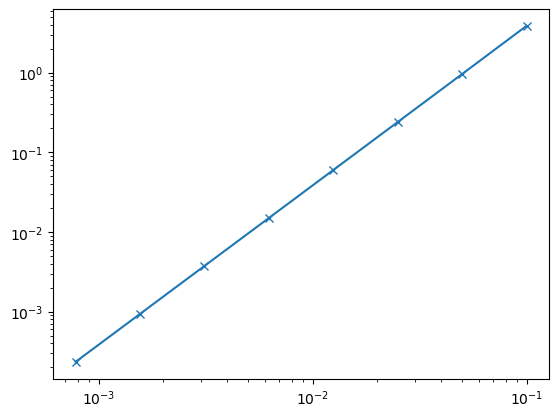

In [367]:
import matplotlib.pyplot as plt
x = x1
gradF = problem.gradF(x)

hs = [0.5**i * 1e-1 for i in range(8)]
errors = np.nan * np.zeros_like(hs)
for i, h in enumerate(hs):
    dF_findiff = gradient_finite_differences(problem.F, x, h=h)
    errors[i] = np.linalg.norm(gradF - dF_findiff)
    if i > 0:
        print(f"h = {h}, errornorm = {errors[i]}, rel={errors[i-1]/errors[i]}")
    else:
        print(f"h = {h}, errornorm = {errors[i]}, rel=")

plt.loglog(hs, errors, "x-")
plt.show()